In [1]:
# ================================
# Standard library
# ================================
import os
import re
from datetime import datetime
from pprint import pprint

# ================================
# Scientific computing
# ================================
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.fft import fft, fftfreq
from scipy.signal import hilbert, welch
from scipy.sparse import coo_matrix

# ================================
# Machine learning - core
# ================================
import lightgbm as lgb
from xgboost import XGBRegressor

# ================================
# Machine learning - scikit-learn
# ================================
import joblib
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.metrics import (
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# ================================
# Progress bar
# ================================
from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib


In [ ]:
# Converts relative paths to absolute ones
ROOT_TRAIN_DATA_FOLDER ='../data/raw/B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data'
ROOT_TEST_DATA_FOLDER = '../data/raw/B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_test_data'

## Parsing

In [ ]:
def parse_vibration_dataset(dataset_path):
    """
    Parsa il dataset di vibrazione e crea un DataFrame pandas con una riga per ogni file.
    Ogni riga contiene gli array completi delle serie temporali di vibrazione.

    Args:
        dataset_path (str): Percorso alla cartella principale del dataset

    Returns:
        pd.DataFrame: DataFrame con colonne etichetta, velocità, torque, rep e array di dati di vibrazione (una riga per file)
    """

    data_list = []
    
    # Prima passata: conta il numero totale di file .txt
    print("Conteggio file in corso...")
    total_files = 0
    for root, dirs, files in os.walk(dataset_path):
        total_files += sum(1 for file in files if file.endswith('.txt'))
    
    print(f"Trovati {total_files} file .txt da processare")

    # Seconda passada: processa i file con progress bar
    with tqdm(total=total_files, desc="Parsing dataset", unit="file") as pbar:
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.endswith('.txt'):
                    folder_name = os.path.basename(root)
                    if 'Pitting_degradation_level_' in folder_name:
                        etichetta_full = folder_name.replace('Pitting_degradation_level_', '')
                        if '(' in etichetta_full:
                            etichetta = etichetta_full.split('(')[0].strip()
                            descrizione = etichetta_full.split('(')[1].replace(')', '').strip()
                        else:
                            etichetta = etichetta_full.strip()
                            descrizione = None
                    else:
                        etichetta = folder_name
                        descrizione = None

                    # ERRORE CORRETTO: regex pattern per V100_200N_2.txt
                    pattern = r'V(\d+)_(\d+)N_(\d+)\.txt'
                    match = re.search(pattern, file)

                    if match:
                        velocita = int(match.group(1))
                        torque = int(match.group(2))
                        rep = int(match.group(3))

                        file_path = os.path.join(root, file)
                        try:
                            # Carica tutti i dati del file una volta sola
                            data = np.loadtxt(file_path)
                            
                            # Calcola informazioni aggiuntive sui dati
                            sampling_rate = 20480  # Hz come specificato nella documentazione
                            duration = len(data) / sampling_rate
                            
                            # Crea un record per l'intero file
                            record = {
                                'file_name': file,
                                'etichetta': etichetta,
                                'health_level': int(etichetta) if etichetta.isdigit() else etichetta,
                                'velocita': velocita,
                                'torque': torque,
                                'rep': rep,
                                'horizontal_acceleration': data[:, 0],  # Array completo
                                'axial_acceleration': data[:, 1],       # Array completo
                                'vertical_acceleration': data[:, 2],    # Array completo
                                'tachometer_signal': data[:, 3],        # Array completo
                                'sampling_rate': sampling_rate,
                                'duration': duration,
                                'num_samples': len(data),
                                'descrizione': descrizione
                            }
                            # ERRORE CORRETTO: aggiungi record invece di data
                            data_list.append(record)

                        except Exception as e:
                            tqdm.write(f"Errore nel leggere il file {file_path}: {e}")
                            continue
                    else:
                        tqdm.write(f"Nome file non riconosciuto: {file}")
                    
                    # Aggiorna la progress bar
                    pbar.update(1)

    df = pd.DataFrame(data_list)

    if not df.empty:
        print("\nOrdinamento dataset...")
        df = df.sort_values(['health_level', 'velocita', 'torque', 'rep']).reset_index(drop=True)
        print(f"Dataset caricato: {len(df)} file processati")
        print(f"Health levels disponibili: {sorted(df['health_level'].unique())}")
        print(f"Condizioni operative (rpm): {sorted(df['velocita'].unique())}")
        print(f"Condizioni operative (torque): {sorted(df['torque'].unique())}")

    df.to_pickle('../data/processed/train_data.pkl')
    
    return df

# Esempio di utilizzo:
# Carica il dataset
print("=== CARICAMENTO DATASET ===")
df = parse_vibration_dataset(ROOT_TRAIN_DATA_FOLDER)

df.head()

In [ ]:
def parse_test_dataset(dataset_path):
    """
    Parsa il dataset di vibrazione e crea un DataFrame pandas con una riga per ogni file.
    Ogni riga contiene gli array completi delle serie temporali di vibrazione.

    Args:
        dataset_path (str): Percorso alla cartella principale del dataset

    Returns:
        pd.DataFrame: DataFrame con colonne etichetta, velocità, torque, rep e array di dati di vibrazione (una riga per file)
    """

    data_list = []
    
    # Prima passata: conta il numero totale di file .txt
    print("Conteggio file in corso...")
    total_files = 0
    for root, dirs, files in os.walk(dataset_path):
        total_files += sum(1 for file in files if file.endswith('.txt'))
    
    print(f"Trovati {total_files} file .txt da processare")

    # Seconda passada: processa i file con progress bar
    with tqdm(total=total_files, desc="Parsing dataset", unit="file") as pbar:
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.endswith('.txt'):

                    # ERRORE CORRETTO: regex pattern per V100_200N_2.txt
                    pattern = re.compile(r'^(\d+)_V(\d+)_(\d+)N(?:_(\d+))?\.txt$', re.IGNORECASE)
                    match = re.search(pattern, file)

                    if match:
                        velocita = int(match.group(2))
                        torque = int(match.group(3))
                        id = int(match.group(1))

                        file_path = os.path.join(root, file)
                        try:
                            # Carica tutti i dati del file una volta sola
                            data = np.loadtxt(file_path)
                            
                            # Calcola informazioni aggiuntive sui dati
                            sampling_rate = 20480  # Hz come specificato nella documentazione
                            duration = len(data) / sampling_rate
                            
                            # Crea un record per l'intero file
                            record = {
                                'file_name': file,
                                'id': id,
                                'velocita': velocita,
                                'torque': torque,
                                'horizontal_acceleration': data[:, 0],  # Array completo
                                'axial_acceleration': data[:, 1],       # Array completo
                                'vertical_acceleration': data[:, 2],    # Array completo
                                'tachometer_signal': data[:, 3],        # Array completo
                                'sampling_rate': sampling_rate,
                                'duration': duration,
                                'num_samples': len(data),
                            }
                            # ERRORE CORRETTO: aggiungi record invece di data
                            data_list.append(record)

                        except Exception as e:
                            tqdm.write(f"Errore nel leggere il file {file_path}: {e}")
                            continue
                    else:
                        tqdm.write(f"Nome file non riconosciuto: {file}")
                    
                    # Aggiorna la progress bar
                    pbar.update(1)

    df = pd.DataFrame(data_list)

    if not df.empty:
        print("\nOrdinamento dataset...")
        df = df.sort_values(['velocita', 'torque']).reset_index(drop=True)
        print(f"Dataset caricato: {len(df)} file processati")
        print(f"Condizioni operative (rpm): {sorted(df['velocita'].unique())}")
        print(f"Condizioni operative (torque): {sorted(df['torque'].unique())}")

    df.to_pickle('../data/processed/test_data.pkl')

    return df


test_df = parse_test_dataset(ROOT_TEST_DATA_FOLDER)

## Downsampling

In [ ]:
df = pd.read_pickle('../data/processed/train_data.pkl')

In [ ]:
def downsample(signal, fs=20480, sec=3):
    """
    Filtra e fa il resample di un segnale ad una lunghezza fissa.
    """
    if len(signal) == fs*sec:
        return signal
    return signal[:fs*sec]  # Truncate or pad to the desired length

def downsample_vibration_dataframe(df, sec=3):
    """
    Applica filtraggio e resample a tutti i segnali accelerometrici e tachimetro nel DataFrame.
    Ritorna un nuovo DataFrame con colonne preprocessate.
    """
    processed_records = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Preprocessing"):
        try:
            record = {
                'file_name': row['file_name'],
                'etichetta': row['etichetta'],
                'health_level': row['health_level'],
                'velocita': row['velocita'],
                'torque': row['torque'],
                'rep': row['rep'],
                'sampling_rate': row['sampling_rate'],
                'descrizione': row['descrizione'],
                'duration': row['duration'],
                'num_samples': row['num_samples']
            }

            # Applica filtro + resample ai 4 segnali
            record['horizontal_acceleration'] = downsample(
                row['horizontal_acceleration'], fs=row['sampling_rate'], sec=sec
            )
            record['axial_acceleration'] = downsample(
                row['axial_acceleration'], fs=row['sampling_rate'], sec=sec
            )
            record['vertical_acceleration'] = downsample(
                row['vertical_acceleration'], fs=row['sampling_rate'], sec=sec
            )
            record['tachometer_signal'] = downsample(
                row['tachometer_signal'], fs=row['sampling_rate'], sec=sec
            )

            processed_records.append(record)

        except Exception as e:
            tqdm.write(f"Errore durante il preprocessing del file {row['file_name']}: {e}")
            continue

    return pd.DataFrame(processed_records)


In [ ]:
features_df = downsample_vibration_dataframe(df, sec=3)

In [14]:
features_df.to_pickle('../data/processed/train_data_dowsampled_walt.pkl')

NameError: name 'features_df' is not defined

In [2]:
features_df = pd.read_pickle("../data/processed/train_data_dowsampled_walt.pkl")

## Feature extraction

In [3]:
# -----------------------
# 1) Pulizia base target
# -----------------------
features_df['health_level'] = pd.to_numeric(features_df['health_level'], errors='coerce')
features_df = features_df.dropna(subset=['health_level']).reset_index(drop=True)

# -----------------------
# 2) Definisci colonne
# -----------------------
scalar_cols = ['velocita', 'torque']  # numeriche scalari già pronte
array_cols = ['horizontal_acceleration', 'axial_acceleration', 'vertical_acceleration', 'tachometer_signal']

scalar_cols = [c for c in scalar_cols if c in features_df.columns]
array_cols  = [c for c in array_cols  if c in features_df.columns]



In [4]:
# Parametri segnale
FS = 20480  # Hz (dal task PHM)
PULSES_PER_REV = 1
TACH_COL_NAME = 'tachometer_signal'

# -----------------------
# 3) Utils
# -----------------------
def _safe_array(x):
    if isinstance(x, (list, tuple, np.ndarray, pd.Series)):
        arr = np.asarray(x, dtype=float).ravel()
    else:
        try:
            arr = np.asarray([x], dtype=float)
        except Exception:
            arr = np.asarray([], dtype=float)
    arr = arr[np.isfinite(arr)]
    return arr

def time_feats(arr):
    if arr.size == 0:
        return {
            'mean': np.nan, 'std': np.nan, 'min': np.nan, 'max': np.nan,
            'median': np.nan, 'p10': np.nan, 'p90': np.nan, 'rms': np.nan,
            'skew': np.nan, 'kurt': np.nan, 'ptp': np.nan, 'iqr': np.nan,
            'zcr': np.nan, 'envelope_rms': np.nan
        }
    feats = {
        'mean': float(np.mean(arr)),
        'std': float(np.std(arr)),
        'min': float(np.min(arr)),
        'max': float(np.max(arr)),
        'median': float(np.median(arr)),
        'p10': float(np.percentile(arr, 10)),
        'p90': float(np.percentile(arr, 90)),
        'rms': float(np.sqrt(np.mean(arr**2))),
        'skew': float(stats.skew(arr, bias=False)) if arr.size > 2 else 0.0,
        'kurt': float(stats.kurtosis(arr, fisher=True, bias=False)) if arr.size > 3 else 0.0,
        'ptp': float(np.ptp(arr)),
        'iqr': float(np.subtract(*np.percentile(arr, [75, 25]))),
        'zcr': float(np.mean(np.abs(np.diff(np.sign(arr))) > 0)) if arr.size > 1 else 0.0,
    }
    try:
        env = np.abs(hilbert(arr))
        feats['envelope_rms'] = float(np.sqrt(np.mean(env**2)))
    except Exception:
        feats['envelope_rms'] = np.nan
    return feats

def tach_feats(arr, fs=FS, pulses_per_rev=PULSES_PER_REV, threshold=0.0):
    if arr.size == 0:
        return {'rpm': np.nan, 'pulse_count': 0, 'ipi_mean': np.nan, 'ipi_std': np.nan, 'ipi_cv': np.nan}
    bin_sig = (arr > threshold).astype(np.uint8)
    idx = np.flatnonzero(bin_sig)
    pulse_count = int(idx.size)
    rpm = np.nan
    if fs is not None and arr.size > 0 and pulses_per_rev > 0:
        window_sec = arr.size / float(fs)
        if window_sec > 0:
            revs = pulse_count / float(pulses_per_rev)
            rpm = (revs / window_sec) * 60.0
    if idx.size > 1:
        ipi = np.diff(idx) / float(fs) if fs else np.diff(idx).astype(float)
        ipi_mean = float(np.mean(ipi))
        ipi_std  = float(np.std(ipi))
        ipi_cv   = float(ipi_std / ipi_mean) if ipi_mean > 0 else np.nan
    else:
        ipi_mean = ipi_std = ipi_cv = np.nan
    return {'rpm': float(rpm), 'pulse_count': pulse_count, 'ipi_mean': ipi_mean, 'ipi_std': ipi_std, 'ipi_cv': ipi_cv}

def psd_band_feats(arr, fs=FS, bands=None):
    if bands is None:
        # bande fino alla Nyquist (10240 Hz), regolabili
        bands = [(0,200),(200,500),(500,1000),(1000,2000),(2000,4000),(4000,8000)]
    if arr.size < 8:
        return {f'band_{lo}_{hi}': np.nan for (lo,hi) in bands}
    # Welch PSD
    try:
        f, Pxx = welch(arr, fs=fs, nperseg=min(2048, len(arr)))
    except Exception:
        return {f'band_{lo}_{hi}': np.nan for (lo,hi) in bands}
    feats = {}
    for (lo, hi) in bands:
        mask = (f >= lo) & (f < hi)
        feats[f'band_{lo}_{hi}'] = float(np.trapz(Pxx[mask], f[mask])) if np.any(mask) else 0.0
    # normalizza per energia totale per robustezza
    total = float(np.trapz(Pxx, f)) if f.size else 1.0
    for (lo, hi) in bands:
        key = f'band_{lo}_{hi}'
        feats[key] = feats[key] / total if total > 0 else 0.0
    return feats

def cross_axis_feats(ax, ay, az):
    feats = {}
    def safe_corr(a,b):
        if len(a) < 2 or len(b) < 2:
            return np.nan
        a = a - np.mean(a)
        b = b - np.mean(b)
        denom = (np.std(a)*np.std(b))
        if denom == 0:
            return 0.0
        return float(np.mean(a*b)/denom)
    feats['corr_xy'] = safe_corr(ax, ay)
    feats['corr_xz'] = safe_corr(ax, az)
    feats['corr_yz'] = safe_corr(ay, az)
    return feats

# -----------------------
# 4) Espansione feature
# -----------------------
def expand_features(df, array_cols, scalar_cols):
    rows = []
    for i, row in df.iterrows():
        feat_row = {}
        # scalari
        for c in scalar_cols:
            feat_row[c] = row[c]
        # array
        ax = _safe_array(row[array_cols[0]]) if 'horizontal_acceleration' in array_cols else np.array([])
        ay = _safe_array(row[array_cols[1]]) if 'axial_acceleration' in array_cols else np.array([])
        az = _safe_array(row[array_cols[2]]) if 'vertical_acceleration' in array_cols else np.array([])
        tach = _safe_array(row[TACH_COL_NAME]) if TACH_COL_NAME in array_cols else np.array([])

        # time feats per-asse
        for sig, name in [(ax,'ax'), (ay,'ay'), (az,'az')]:
            if sig.size > 0:
                tf = time_feats(sig)
                tf = {f'{name}_{k}': v for k,v in tf.items()}
                feat_row.update(tf)

                pf = psd_band_feats(sig, fs=FS)
                pf = {f'{name}_{k}': v for k,v in pf.items()}
                feat_row.update(pf)

        # cross-axis
        if ax.size > 0 and ay.size > 0 and az.size > 0:
            feat_row.update(cross_axis_feats(ax, ay, az))

        # tach
        if tach.size > 0:
            tfeat = tach_feats(tach, fs=FS, pulses_per_rev=PULSES_PER_REV, threshold=0.0)
            feat_row.update(tfeat)

        # interazioni operative
        if 'velocita' in feat_row and 'torque' in feat_row:
            v = feat_row['velocita']
            t = feat_row['torque']
            feat_row['v_times_t'] = v * t
            feat_row['v_sq'] = v**2
            feat_row['t_sq'] = t**2
            if 'rpm' in feat_row and np.isfinite(feat_row['rpm']):
                rpm = feat_row['rpm']
                # normalizzazioni semplici
                feat_row['v_over_rpm'] = v / (rpm + 1e-6)
                feat_row['t_over_rpm'] = t / (rpm + 1e-6)

        rows.append(feat_row)

    X_full = pd.DataFrame(rows)
    # imputazione semplice
    X_full = X_full.replace([np.inf, -np.inf], np.nan)
    X_full = X_full.fillna(X_full.median(numeric_only=True))
    return X_full


In [5]:
print("[*] Genero feature...")
X_full = expand_features(features_df, array_cols=array_cols, scalar_cols=scalar_cols)
y = features_df['health_level'].astype(float).values

print(f"[*] Shape X_full: {X_full.shape}, n_features = {X_full.shape[1]}")

[*] Genero feature...
[*] Shape X_full: (2016, 75), n_features = 75


In [6]:
X_full

,velocita,torque,ax_mean,ax_std,ax_min,ax_max,ax_median,ax_p10,ax_p90,ax_rms,...,rpm,pulse_count,ipi_mean,ipi_std,ipi_cv,v_times_t,v_sq,t_sq,v_over_rpm,t_over_rpm
0,100,50,-0.169319,0.162043,-0.794698,0.118969,-0.136461,-0.413488,0.017492,0.234365,...,60.0,3,1.082007,0.000659,0.000609,5000,10000,2500,1.666667,0.833333
1,100,50,0.000265,0.071211,-0.282226,0.157426,0.003846,-0.097011,0.089568,0.071211,...,60.0,3,1.082153,0.000220,0.000203,5000,10000,2500,1.666667,0.833333
2,100,50,-0.000159,0.074463,-0.336066,0.162016,0.003598,-0.102221,0.093041,0.074463,...,40.0,2,1.081201,0.000000,0.000000,5000,10000,2500,2.500000,1.250000
3,100,50,-0.000540,0.075078,-0.290537,0.164125,0.003101,-0.103723,0.093662,0.075080,...,40.0,2,1.082666,0.000000,0.000000,5000,10000,2500,2.500000,1.250000
4,100,50,-0.000262,0.075467,-0.300958,0.184594,0.003722,-0.103090,0.094406,0.075467,...,60.0,3,1.082373,0.000195,0.000180,5000,10000,2500,1.666667,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,3600,50,0.003271,0.936696,-4.257450,3.650200,0.005645,-1.185720,1.187097,0.936702,...,2000.0,100,0.030001,0.000024,0.000802,180000,12960000,2500,1.800000,0.025000
2012,3600,50,-0.000045,0.932316,-4.302978,4.262537,0.001116,-1.186712,1.181998,0.932316,...,2000.0,100,0.030002,0.000024,0.000807,180000,12960000,2500,1.800000,0.025000
2013,3600,100,-0.001060,1.102834,-4.373690,4.765580,0.004094,-1.419564,1.389803,1.102835,...,2000.0,100,0.030002,0.000024,0.000807,360000,12960000,10000,1.800000,0.050000
2014,3600,100,-0.003609,1.074484,-4.859490,4.633213,0.003349,-1.377658,1.362250,1.074491,...,2000.0,100,0.030001,0.000024,0.000804,360000,12960000,10000,1.800000,0.050000


## Training

In [7]:
# -----------------------
# 5) Split
# -----------------------
y_int = y.astype(int)
X = X_full.astype(np.float32).values

X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_int
)

In [17]:
# ============================================
# MODEL SELECTION - CLASSIFICAZIONE (PULITO)
# ============================================

# Utilità e strumenti
import warnings
warnings.filterwarnings("ignore")

from pprint import pprint
from contextlib import contextmanager
from tqdm.auto import tqdm  # progress bar

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import (
    RandomizedSearchCV, cross_val_score, StratifiedKFold
)

# Modelli di classificazione (Classifiers)
from sklearn.ensemble import (
    RandomForestClassifier,
    HistGradientBoostingClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier
)
from sklearn.linear_model import RidgeClassifier, LogisticRegression

# Boosting esterni
from xgboost import XGBClassifier
import lightgbm as lgb

# --------------------------------------------
# Helper: tqdm_joblib per aggiornare la barra con joblib
# --------------------------------------------
@contextmanager
def tqdm_joblib(tqdm_object):
    """Mostra l'avanzamento di joblib nella progress bar di tqdm."""
    try:
        from joblib import parallel
        class TqdmBatchCompletionCallback(parallel.BatchCompletionCallBack):
            def __call__(self, *args, **kwargs):
                tqdm_object.update(n=self.batch_size)
                return super().__call__(*args, **kwargs)
        old_callback = parallel.BatchCompletionCallBack
        parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
        yield
    finally:
        parallel.BatchCompletionCallBack = old_callback
        tqdm_object.close()

# -----------------------
# 1) Configurazioni
# -----------------------
SCORING = "accuracy"  # oppure "f1_macro", ecc.

# y: encoding 0..K-1 (richiesto per XGBoost)
le = LabelEncoder()
y_tr_enc = le.fit_transform(y_tr)
n_classes = len(le.classes_)

# CV stratificata e riproducibile
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# -----------------------
# 2) Pipeline modelli
#    (niente scaler davanti agli alberi)
# -----------------------

# Random Forest
rf = Pipeline([
    ("model", RandomForestClassifier(random_state=42, n_jobs=-1))
])
rf_param_dist = {
    "model__n_estimators": [200, 400, 600, 800],
    "model__max_depth": [6, 8, 10, 12, None],
    "model__min_samples_leaf": [1, 2, 5, 10],
    "model__min_samples_split": [2, 5, 10],
    "model__max_features": ["sqrt", "log2", 0.3, 0.5, 0.8],
    "model__class_weight": [None, "balanced"]
}

# Histogram Gradient Boosting
hgb = Pipeline([
    ("model", HistGradientBoostingClassifier(random_state=42))
])
hgb_param_dist = {
    "model__max_depth": [None, 4, 6, 8],
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__max_iter": [200, 400, 800],
    "model__l2_regularization": [0.0, 0.1, 1.0],
    "model__min_samples_leaf": [10, 20, 30, 50]
}

# XGBoost (multi-classe esplicito)
xgb = Pipeline([
    ("model", XGBClassifier(
        random_state=42,
        n_estimators=200,
        n_jobs=-1,
        verbosity=0,
        objective="multi:softprob",
        eval_metric="mlogloss",
        num_class=n_classes
    ))
])
xgb_param_dist = {
    "model__n_estimators": [200, 400, 600, 800],
    "model__max_depth": [3, 4, 6, 8],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.15],
    "model__subsample": [0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.8, 0.9, 1.0],
    "model__reg_alpha": [0, 0.1, 1],
    "model__reg_lambda": [1, 1.5, 2],
}

# LightGBM
lgbm = Pipeline([
    ("model", lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1))
])
lgbm_param_dist = {
    "model__n_estimators": [200, 400, 600, 800],
    "model__max_depth": [3, 4, 6, 8, -1],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.15],
    "model__subsample": [0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.8, 0.9, 1.0],
    "model__reg_alpha": [0, 0.1, 1],
    "model__reg_lambda": [0, 0.1, 1],
    "model__num_leaves": [31, 50, 100, 200],
    "model__class_weight": [None, "balanced"]
}

# Gradient Boosting classico
gb = Pipeline([
    ("model", GradientBoostingClassifier(random_state=42))
])
gb_param_dist = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [3, 4, 6, 8],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.15],
    "model__subsample": [0.8, 0.9, 1.0],
    "model__max_features": ["sqrt", "log2", 0.3, 0.5]
}

# Extra Trees
et = Pipeline([
    ("model", ExtraTreesClassifier(random_state=42, n_jobs=-1))
])
et_param_dist = {
    "model__n_estimators": [200, 400, 600, 800],
    "model__max_depth": [6, 8, 10, 12, None],
    "model__min_samples_leaf": [1, 2, 5, 10],
    "model__min_samples_split": [2, 5, 10],
    "model__max_features": ["sqrt", "log2", 0.3, 0.5, 0.8],
    "model__class_weight": [None, "balanced"]
}

# Ridge Classifier (qui lo scaler serve)
ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RidgeClassifier())
])
ridge_param_dist = {
    "model__alpha": [0.1, 1.0, 10.0, 100.0, 1000.0],
    "model__class_weight": [None, "balanced"]
}

# Logistic Regression con Elastic Net (qui lo scaler serve)
elastic = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        penalty="elasticnet", solver="saga", max_iter=5000, n_jobs=-1, random_state=42
    ))
])
elastic_param_dist = {
    "model__C": [0.01, 0.1, 1.0, 10.0],
    "model__l1_ratio": [0.1, 0.5, 0.7, 0.9],
    "model__class_weight": [None, "balanced"]
}

# -----------------------
# 3) Funzione di tuning
# -----------------------
def fit_search(name, pipe, param_dist, *, n_iter=25, cv=cv):
    print(f"\n[*] Tuning {name}...")
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring=SCORING,
        cv=cv,
        verbose=0,               # la barra di tqdm si occupa dell'output
        random_state=42,
        n_jobs=-1,
        error_score="raise"
    )
    total_steps = n_iter * (cv.get_n_splits(X_tr, y_tr_enc))
    with tqdm_joblib(tqdm(total=total_steps, desc=f"Tuning {name}", leave=True)):
        search.fit(X_tr, y_tr_enc)
    print(f"[+] Best {SCORING.upper()} (cv) {name}: {search.best_score_:.4f}")
    print(f"[+] Best params {name}:")
    pprint(search.best_params_)
    return search

# -----------------------
# 4) Training di tutti i modelli
# -----------------------
print("=" * 60)
print("TRAINING MODELLI (Classificazione)")
print("=" * 60)

rf_search    = fit_search("RandomForest", rf, rf_param_dist, n_iter=25, cv=cv)
hgb_search   = fit_search("HistGradientBoosting", hgb, hgb_param_dist, n_iter=25, cv=cv)
xgb_search   = fit_search("XGBoost", xgb, xgb_param_dist, n_iter=30, cv=cv)
lgbm_search  = fit_search("LightGBM", lgbm, lgbm_param_dist, n_iter=30, cv=cv)
gb_search    = fit_search("GradientBoosting", gb, gb_param_dist, n_iter=25, cv=cv)
et_search    = fit_search("ExtraTrees", et, et_param_dist, n_iter=25, cv=cv)
ridge_search = fit_search("RidgeClassifier", ridge, ridge_param_dist, n_iter=10, cv=cv)
elastic_search = fit_search("LogReg_ElasticNet", elastic, elastic_param_dist, n_iter=15, cv=cv)

# -----------------------
# 5) Confronto finale
# -----------------------
searches = {
    "RandomForest": rf_search,
    "HistGradientBoosting": hgb_search,
    "XGBoost": xgb_search,
    "LightGBM": lgbm_search,
    "GradientBoosting": gb_search,
    "ExtraTrees": et_search,
    "RidgeClassifier": ridge_search,
    "LogReg_ElasticNet": elastic_search,
}

print("\n" + "=" * 60)
print("RISULTATI FINALI - CONFRONTO MODELLI (Classificazione)")
print("=" * 60)
print(f"{'Modello':<20} {'Best CV ' + SCORING.upper():<18} {'Std':<10}")
print("-" * 55)

results = []
for name, search in searches.items():
    cv_scores = cross_val_score(
        search.best_estimator_, X_tr, y_tr_enc,
        cv=cv, scoring=SCORING, n_jobs=-1
    )
    score_mean = cv_scores.mean()
    score_std = cv_scores.std()
    results.append((name, score_mean, score_std, search.best_estimator_))
    print(f"{name:<20} {score_mean:<18.4f} {score_std:<10.4f}")

# Ordina per performance (maggiore è meglio)
results.sort(key=lambda x: -x[1])
print(f"\n🏆 Miglior modello: {results[0][0]} ({SCORING.upper()}: {results[0][1]:.4f} ± {results[0][2]:.4f})")

# Salva il miglior modello
best_model = results[0][3]
print(f"\nModello selezionato salvato come 'best_model'")

# -----------------------
# 6) Uso del modello migliore
# -----------------------
# Esempio:
# y_pred_enc = best_model.predict(X_test)
# y_pred = le.inverse_transform(y_pred_enc)  # ritorna alle etichette originali


TRAINING MODELLI (Classificazione)

[*] Tuning RandomForest...


Tuning RandomForest:   0%|          | 0/75 [00:00<?, ?it/s]

[+] Best ACCURACY (cv) RandomForest: 0.9497
[+] Best params RandomForest:
{'model__class_weight': None,
 'model__max_depth': None,
 'model__max_features': 'log2',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 600}

[*] Tuning HistGradientBoosting...


Tuning HistGradientBoosting:   0%|          | 0/75 [00:00<?, ?it/s]

[+] Best ACCURACY (cv) HistGradientBoosting: 0.9373
[+] Best params HistGradientBoosting:
{'model__l2_regularization': 0.0,
 'model__learning_rate': 0.03,
 'model__max_depth': None,
 'model__max_iter': 800,
 'model__min_samples_leaf': 20}

[*] Tuning XGBoost...


Tuning XGBoost:   0%|          | 0/90 [00:00<?, ?it/s]

[+] Best ACCURACY (cv) XGBoost: 0.9287
[+] Best params XGBoost:
{'model__colsample_bytree': 0.9,
 'model__learning_rate': 0.15,
 'model__max_depth': 8,
 'model__n_estimators': 400,
 'model__reg_alpha': 0.1,
 'model__reg_lambda': 1,
 'model__subsample': 0.9}

[*] Tuning LightGBM...


Tuning LightGBM:   0%|          | 0/90 [00:00<?, ?it/s]

[+] Best ACCURACY (cv) LightGBM: 0.9380
[+] Best params LightGBM:
{'model__class_weight': None,
 'model__colsample_bytree': 0.8,
 'model__learning_rate': 0.1,
 'model__max_depth': -1,
 'model__n_estimators': 600,
 'model__num_leaves': 31,
 'model__reg_alpha': 0,
 'model__reg_lambda': 0,
 'model__subsample': 0.9}

[*] Tuning GradientBoosting...


Tuning GradientBoosting:   0%|          | 0/75 [00:00<?, ?it/s]

[+] Best ACCURACY (cv) GradientBoosting: 0.9510
[+] Best params GradientBoosting:
{'model__learning_rate': 0.1,
 'model__max_depth': 8,
 'model__max_features': 'sqrt',
 'model__n_estimators': 400,
 'model__subsample': 0.9}

[*] Tuning ExtraTrees...


Tuning ExtraTrees:   0%|          | 0/75 [00:00<?, ?it/s]

[+] Best ACCURACY (cv) ExtraTrees: 0.9497
[+] Best params ExtraTrees:
{'model__class_weight': 'balanced',
 'model__max_depth': 12,
 'model__max_features': 0.3,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 800}

[*] Tuning RidgeClassifier...


Tuning RidgeClassifier:   0%|          | 0/30 [00:00<?, ?it/s]

[+] Best ACCURACY (cv) RidgeClassifier: 0.6656
[+] Best params RidgeClassifier:
{'model__alpha': 0.1, 'model__class_weight': None}

[*] Tuning LogReg_ElasticNet...


Tuning LogReg_ElasticNet:   0%|          | 0/45 [00:00<?, ?it/s]

[+] Best ACCURACY (cv) LogReg_ElasticNet: 0.7606
[+] Best params LogReg_ElasticNet:
{'model__C': 10.0, 'model__class_weight': 'balanced', 'model__l1_ratio': 0.7}

RISULTATI FINALI - CONFRONTO MODELLI (Classificazione)
Modello              Best CV ACCURACY   Std       
-------------------------------------------------------
RandomForest         0.9497             0.0130    
HistGradientBoosting 0.9373             0.0141    
XGBoost              0.9287             0.0089    
LightGBM             0.9380             0.0158    
GradientBoosting     0.9510             0.0075    
ExtraTrees           0.9497             0.0092    
RidgeClassifier      0.6656             0.0442    
LogReg_ElasticNet    0.7606             0.0331    

🏆 Miglior modello: GradientBoosting (ACCURACY: 0.9510 ± 0.0075)

Modello selezionato salvato come 'best_model'


In [18]:
# -----------------------
# 6) Helper per valutazione corretta (etichetta reale + proba allineata)
# -----------------------
def align_proba_to_labels(y_proba_enc, le, target_labels):
    """
    Riordina/seleziona le colonne di y_proba_enc (che sono nell'ordine le.classes_)
    per farle combaciare con target_labels (etichette reali nell'ordine desiderato).
    """
    target_labels = np.asarray(target_labels)
    idx = [np.where(le.classes_ == c)[0][0] for c in target_labels]
    return y_proba_enc[:, idx]


from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

# -----------------------
# 7) Valutazione su validation (Classificazione) - FIXED
# -----------------------
def evaluate(model, X_va, y_va, model_name, print_cm=True, print_report=True, le=None):
    if le is None:
        raise ValueError("Passa la LabelEncoder usata in training: evaluate(..., le=le)")

    # Predizione (enc) -> inverse transform alle etichette reali
    y_pred_enc = model.predict(X_va)
    y_pred = le.inverse_transform(np.asarray(y_pred_enc).ravel())

    # Etichette reali presenti in y_va (ordinate)
    labels_va = np.array(sorted(np.unique(y_va)))

    # Probabilità allineate alle etichette reali
    y_proba = None
    if hasattr(model, "predict_proba"):
        try:
            y_proba_enc = model.predict_proba(X_va)  # colonne nell'ordine le.classes_
            y_proba = align_proba_to_labels(y_proba_enc, le, labels_va)
        except Exception:
            y_proba = None

    # Metriche
    acc  = accuracy_score(y_va, y_pred)
    bacc = balanced_accuracy_score(y_va, y_pred)
    f1m  = f1_score(y_va, y_pred, average="macro")
    f1w  = f1_score(y_va, y_pred, average="weighted")

    auc = None
    if y_proba is not None and len(labels_va) > 1:
        try:
            auc = roc_auc_score(y_va, y_proba, multi_class="ovr", labels=labels_va)
        except Exception:
            auc = None

    # Confusion matrix (etichette reali)
    cm = confusion_matrix(y_va, y_pred, labels=labels_va)
    cm_df = pd.DataFrame(cm, index=[f"true_{l}" for l in labels_va],
                            columns=[f"pred_{l}" for l in labels_va])

    print(f"\n=== {model_name} on validation ===")
    print(f"Accuracy:            {acc:.4f}")
    print(f"Balanced Accuracy:   {bacc:.4f}")
    print(f"F1 Macro:            {f1m:.4f}")
    print(f"F1 Weighted:         {f1w:.4f}")
    if auc is not None:
        print(f"ROC AUC:             {auc:.4f}")

    if print_report:
        print("\nClassification report:")
        print(classification_report(y_va, y_pred, digits=4, labels=labels_va))

    if print_cm:
        print("\nConfusion matrix:")
        print(cm_df)

    return {
        "name": model_name,
        "accuracy": acc,
        "balanced_accuracy": bacc,
        "f1_macro": f1m,
        "f1_weighted": f1w,
        "auc": auc,
        "y_pred": y_pred,
        "cm_df": cm_df
    }

# Valuta tutti i best_estimator_ ottenuti dallo step di tuning
val_results = []
print("\n" + "=" * 60)
print("VALUTAZIONE SU VALIDATION - TUTTI I MODELLI (Classificazione)")
print("=" * 60)

for name, search in searches.items():
    res = evaluate(search.best_estimator_, X_va, y_va, name,
                   print_cm=True, print_report=False, le=le)
    val_results.append(res)

# -----------------------
# 8) Tabella riassuntiva ordinata per metrica principale (SCORING)
# -----------------------
metric_key_map = {
    "f1_macro": "f1_macro",
    "f1": "f1_macro",               # se stavi usando 'f1' binario, usiamo macro
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy"
}
key = metric_key_map.get(SCORING, "f1_macro")

summary_rows = []
for r in val_results:
    summary_rows.append([
        r["name"], r["accuracy"], r["balanced_accuracy"], r["f1_macro"], r["f1_weighted"], r["auc"]
    ])

summary_df = pd.DataFrame(
    summary_rows,
    columns=["Model", "Accuracy", "Balanced Acc", "F1 Macro", "F1 Weighted", "AUC"]
).sort_values(by={"accuracy": "Accuracy",
                  "balanced_accuracy": "Balanced Acc",
                  "f1_macro": "F1 Macro"}.get(SCORING, "F1 Macro"),
              ascending=False)

print("\n" + "-" * 60)
print(f"RIEPILOGO ORDINATO PER {SCORING.upper()} (validation)")
print("-" * 60)
print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.4f}" if pd.notnull(x) else "NA"))

# Migliore su validation per metrica SCORING
best_val = max(val_results, key=lambda r: r.get(key, r["f1_macro"]))
best_name_val = best_val["name"]
best_model_val = searches[best_name_val].best_estimator_
print(f"\n[***] Best model on validation ({SCORING.upper()}): {best_name_val} "
      f"({SCORING.upper()}={best_val.get(key):.4f})")

# (Opzionale) aggiorna 'best_model' con il migliore su validation
best_model = best_model_val
print("Aggiornato 'best_model' con il migliore su validation.")


VALUTAZIONE SU VALIDATION - TUTTI I MODELLI (Classificazione)

=== RandomForest on validation ===
Accuracy:            0.9876
Balanced Accuracy:   0.9872
F1 Macro:            0.9876
F1 Weighted:         0.9877
ROC AUC:             0.9997

Confusion matrix:
          pred_0.0  pred_1.0  pred_2.0  pred_3.0  pred_4.0  pred_6.0  pred_8.0
true_0.0        57         1         0         0         0         0         0
true_1.0         0        59         0         0         0         0         0
true_2.0         0         0        58         0         0         0         0
true_3.0         0         3         0        51         0         0         0
true_4.0         0         0         0         0        61         0         0
true_6.0         0         0         0         0         0        55         0
true_8.0         0         0         1         0         0         0        58

=== HistGradientBoosting on validation ===
Accuracy:            0.9851
Balanced Accuracy:   0.9849
F1 Macro: 

In [ ]:
# ============================================
# ANALISI RISULTATI E SELEZIONE FINALE
# ============================================

import pandas as pd
import numpy as np

# Dati dai tuoi risultati
cv_results = {
    'Model': ['GradientBoosting', 'RandomForest', 'ExtraTrees', 'LightGBM', 
              'HistGradientBoosting', 'XGBoost', 'LogReg_ElasticNet', 'RidgeClassifier'],
    'CV_Score': [0.9510, 0.9497, 0.9497, 0.9380, 0.9373, 0.9287, 0.7606, 0.6656],
    'CV_Std': [0.0075, 0.0130, 0.0092, 0.0158, 0.0141, 0.0089, 0.0331, 0.0442]
}

val_results = {
    'Model': ['RandomForest', 'GradientBoosting', 'ExtraTrees', 'HistGradientBoosting',
              'XGBoost', 'LightGBM', 'LogReg_ElasticNet', 'RidgeClassifier'],
    'Val_Accuracy': [0.9876, 0.9876, 0.9876, 0.9851, 0.9851, 0.9802, 0.7797, 0.6832],
    'Val_F1_Macro': [0.9876, 0.9875, 0.9876, 0.9852, 0.9853, 0.9802, 0.7771, 0.6666],
    'Val_AUC': [0.9997, 1.0000, 0.9999, 0.9998, 0.9995, 0.9999, 0.9702, np.nan]
}

# Unisci i risultati
cv_df = pd.DataFrame(cv_results)
val_df = pd.DataFrame(val_results)
combined = pd.merge(cv_df, val_df, on='Model', how='inner')

# Aggiungi ranking
combined['CV_Rank'] = combined['CV_Score'].rank(ascending=False)
combined['Val_Rank'] = combined['Val_Accuracy'].rank(ascending=False)
combined['Avg_Rank'] = (combined['CV_Rank'] + combined['Val_Rank']) / 2

# Ordina per ranking medio
combined = combined.sort_values('Avg_Rank').reset_index(drop=True)

print("ANALISI COMPARATIVA CV vs VALIDATION")
print("=" * 60)
print(combined[['Model', 'CV_Score', 'CV_Std', 'Val_Accuracy', 'Val_F1_Macro', 
               'CV_Rank', 'Val_Rank', 'Avg_Rank']].round(4))

print("\n" + "=" * 60)
print("RACCOMANDAZIONI")
print("=" * 60)

# Top 3 modelli più stabili
top_models = combined.head(3)
print("🏆 TOP 3 MODELLI (ranking medio CV + Validation):")
for idx, row in top_models.iterrows():
    print(f"{idx+1}. {row['Model']:<20} | CV: {row['CV_Score']:.4f}±{row['CV_Std']:.4f} | Val: {row['Val_Accuracy']:.4f}")

print(f"\n🎯 MODELLO RACCOMANDATO: {top_models.iloc[0]['Model']}")

# Analisi stabilità
print(f"\n📊 ANALISI STABILITÀ:")
stable_models = combined[combined['CV_Std'] < 0.012]  # Bassa variabilità CV
print("Modelli con bassa variabilità in CV (std < 0.012):")
for _, row in stable_models.iterrows():
    consistency = abs(row['CV_Score'] - row['Val_Accuracy'])
    print(f"  • {row['Model']:<20} | Consistency: {consistency:.4f}")

# Controlla overfitting
print(f"\n🔍 CHECK OVERFITTING:")
for _, row in combined.iterrows():
    diff = row['Val_Accuracy'] - row['CV_Score']
    if diff > 0.02:  # Miglioramento > 2%
        status = "⚠️  Possibile validation set favorevole"
    elif diff < -0.02:  # Peggioramento > 2%
        status = "❌ Possibile overfitting"
    else:
        status = "✅ Consistente"
    print(f"  • {row['Model']:<20} | Diff: {diff:+.4f} | {status}")

print(f"\n" + "=" * 60)
print("DECISIONE FINALE")
print("=" * 60)

best_model = top_models.iloc[0]['Model']
print(f"""
✅ MODELLO SELEZIONATO: {best_model}

RAGIONI:
1. Performance eccellente sia in CV che in validation
2. Buona consistenza tra train e validation
3. Ranking complessivo migliore

PERFORMANCE:
• Cross-Validation: {top_models.iloc[0]['CV_Score']:.4f} ± {top_models.iloc[0]['CV_Std']:.4f}
• Validation:       {top_models.iloc[0]['Val_Accuracy']:.4f}
• F1 Macro:         {top_models.iloc[0]['Val_F1_Macro']:.4f}
• AUC:              {top_models.iloc[0]['Val_AUC']:.4f}

📝 NOTA: I tre migliori modelli (RandomForest, GradientBoosting, ExtraTrees) 
hanno performance molto simili. La scelta finale può basarsi anche su:
- Interpretabilità (RandomForest/ExtraTrees > GradientBoosting)  
- Velocità di training/predizione
- Memoria utilizzata
- Facilità di deployment
""")

# Suggerimenti aggiuntivi
print(f"\n💡 SUGGERIMENTI AGGIUNTIVI:")
print(f"""
1. ENSEMBLE: Considera di creare un ensemble dei top 3 modelli
2. TEST FINALE: Valuta il modello scelto su un test set completamente nuovo
3. FEATURE IMPORTANCE: Analizza le feature più importanti del modello selezionato
4. THRESHOLD TUNING: Per problemi sbilanciati, considera di ottimizzare la soglia
5. CROSS-VALIDATION PIÙ ROBUSTA: Usa 5-fold o 10-fold CV per risultati più stabili
""")

# Codice per ensemble semplice
print(f"\n" + "=" * 60)
print("CODICE PER ENSEMBLE (Opzionale)")
print("=" * 60)
print("""
# Ensemble dei top 3 modelli
from sklearn.ensemble import VotingClassifier

top_3_models = [
    ('rf', searches['RandomForest'].best_estimator_),
    ('gb', searches['GradientBoosting'].best_estimator_), 
    ('et', searches['ExtraTrees'].best_estimator_)
]

ensemble = VotingClassifier(
    estimators=top_3_models,
    voting='soft'  # usa le probabilità
)

# Training dell'ensemble
ensemble.fit(X_tr, y_tr_enc)

# Valutazione
ensemble_result = evaluate_model(ensemble, X_va, y_va, "Ensemble_Top3", le)
print(f"Ensemble Accuracy: {ensemble_result['accuracy']:.4f}")
""")

In [ ]:
# -----------------------
# 8) Importanza delle feature (permutation importance) - Classificazione
# -----------------------
from sklearn.inspection import permutation_importance

print("\n[*] Calcolo permutation importance sul best model (può essere lento)...")

# Usa la metrica di classificazione scelta nello step 6/7
SCORING = globals().get("SCORING", "f1_macro")
y_va_enc = le.transform(y_va)

perm = permutation_importance(
    best_model, X_va, y_va_enc,      # <<<< usa y_va_enc
    scoring=SCORING, n_repeats=20,   # alza un po’ i repeats per stabilità
    random_state=42, n_jobs=-1
)

importances = pd.Series(perm.importances_mean, index=X_full.columns).sort_values(ascending=False)
print(importances.head(25))


importances = pd.Series(perm.importances_mean, index=X_full.columns).sort_values(ascending=False)
topk = 25
print(f"\nTop {topk} feature (permutation importance - {SCORING}):")
print(importances.head(topk))



[*] Calcolo permutation importance sul best model (può essere lento)...


ValueError: Found input variables with inconsistent numbers of samples: [1612, 404]

In [20]:
# -----------------------
# 8) Salvataggio del modello migliore (Classificazione)
# -----------------------
import os, json, joblib
from datetime import datetime

# Crea una cartella per i modelli se non esiste
os.makedirs('models', exist_ok=True)

# Timestamp per rendere unico il nome del file
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Salvataggio con joblib (raccomandato per modelli scikit-learn)
model_filename = f'models/best_model_classification_{best_name_val}_{timestamp}.joblib'
joblib.dump(best_model, model_filename)
print(f"Modello salvato con joblib in: {model_filename}")

# Prepara metadati con metriche di classificazione
SCORING = globals().get("SCORING", "f1_macro")
metadata = {
    'model_name': best_name_val,
    'scoring': SCORING,
    'accuracy':        best_val['accuracy'],
    'balanced_accuracy': best_val['balanced_accuracy'],
    'f1_macro':        best_val['f1_macro'],
    'f1_weighted':     best_val['f1_weighted'],
    'auc':             best_val['auc'],
    'timestamp':       timestamp,
    'best_params':     searches[best_name_val].best_params_
}

metadata_filename = f'models/best_model_classification_metadata_{best_name_val}_{timestamp}.json'
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Metadati salvati in: {metadata_filename}")

# Per caricare il modello in futuro:
"""
from joblib import load as joblib_load
loaded_model = joblib_load(model_filename)

with open(metadata_filename, 'r') as f:
    metadata = json.load(f)
"""

print(f"\n[***] Modello migliore '{best_name_val}' salvato con successo!")
print(f"     {SCORING.upper()}: {best_val.get(SCORING if SCORING in ['accuracy','balanced_accuracy'] else 'f1_macro'):.4f}")
print(f"     File: {model_filename}")
print(f"     Metadati: {metadata_filename}")


Modello salvato con joblib in: models/best_model_classification_RandomForest_20250823_214924.joblib
Metadati salvati in: models/best_model_classification_metadata_RandomForest_20250823_214924.json

[***] Modello migliore 'RandomForest' salvato con successo!
     ACCURACY: 0.9876
     File: models/best_model_classification_RandomForest_20250823_214924.joblib
     Metadati: models/best_model_classification_metadata_RandomForest_20250823_214924.json


## Testing

In [8]:
test_df = pd.read_pickle('../data/processed/test_data.pkl')

In [9]:
array_cols = ['horizontal_acceleration', 'axial_acceleration', 'vertical_acceleration', 'tachometer_signal']
scalar_cols = ['velocita', 'torque'] 
test_full = expand_features(test_df, array_cols=array_cols, scalar_cols=scalar_cols)
test_full

,velocita,torque,ax_mean,ax_std,ax_min,ax_max,ax_median,ax_p10,ax_p90,ax_rms,...,rpm,pulse_count,ipi_mean,ipi_std,ipi_cv,v_times_t,v_sq,t_sq,v_over_rpm,t_over_rpm
0,100,50,0.000470,0.189005,-0.880544,0.411491,0.018732,-0.262377,0.224168,0.189006,...,54.771784,11,1.082280,0.000435,0.000402,5000,10000,2500,1.825758,0.912879
1,100,50,-0.000101,0.152046,-0.676597,0.352317,0.007319,-0.204195,0.188564,0.152046,...,54.771784,11,1.082236,0.000264,0.000244,5000,10000,2500,1.825758,0.912879
2,100,50,0.000135,0.038641,-0.143656,0.108424,0.001737,-0.052475,0.049498,0.038641,...,54.545455,11,1.082222,0.000392,0.000362,5000,10000,2500,1.833333,0.916667
3,100,50,-0.000111,0.188699,-0.864913,0.400202,0.017988,-0.262501,0.223547,0.188699,...,54.771784,11,1.082217,0.000132,0.000122,5000,10000,2500,1.825758,0.912879
4,100,50,-0.000034,0.150834,-0.609979,0.322295,0.007443,-0.202706,0.187075,0.150834,...,54.771784,11,1.082207,0.000194,0.000180,5000,10000,2500,1.825758,0.912879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,3600,100,-0.003586,1.274652,-4.568457,5.180049,-0.024873,-1.646833,1.676321,1.274657,...,2006.557377,102,0.030001,0.000025,0.000837,360000,12960000,10000,1.794118,0.049837
796,3600,100,-0.001434,1.061359,-4.559400,5.011086,-0.003225,-1.355923,1.358069,1.061360,...,1993.548387,103,0.030001,0.000024,0.000804,360000,12960000,10000,1.805825,0.050162
797,3600,100,0.003537,1.069601,-5.260684,5.119634,0.013212,-1.353355,1.342935,1.069607,...,2012.903226,104,0.030001,0.000024,0.000805,360000,12960000,10000,1.788462,0.049679
798,3600,100,-0.007096,1.067926,-5.602705,5.226941,0.007940,-1.363565,1.328544,1.067949,...,2012.903226,104,0.030001,0.000024,0.000803,360000,12960000,10000,1.788462,0.049679


In [10]:
best_model = joblib.load('models/best_model_classification_RandomForest_20250823_214924.joblib')

In [36]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# -------------------------
# CONFIG
# -------------------------
BASE_CLASSES = [4, 6, 8]
MISSING_MAP  = {4: 5, 6: 7, 8: 9}
CONTAMINATION = 0.05
RNG_SEED = 42

# -------------------------
# UTILS COMPATTI
# -------------------------
def get_model_classes(model):
    if hasattr(model, "classes_"):
        return model.classes_
    if hasattr(model, "named_steps"):
        step = model.named_steps.get("model", list(model.named_steps.values())[-1])
        if hasattr(step, "classes_"):
            return step.classes_
    if hasattr(model, "steps"):
        last = model.steps[-1][1]
        if hasattr(last, "classes_"):
            return last.classes_
    raise AttributeError("Impossibile recuperare classes_ dal best_model")

def enc_to_real_mapper(best_model, y_tr):
    enc = get_model_classes(best_model)
    real_sorted = np.sort(np.unique(y_tr))
    if set(enc.tolist()) == set(real_sorted.tolist()):
        col_labels_real = enc.astype(int)
        enc_to_real = lambda y_enc: np.asarray(y_enc, int).ravel()
    else:
        col_labels_real = real_sorted[enc.astype(int)]
        enc_to_real = lambda y_enc: real_sorted[np.asarray(y_enc, int).ravel()]
    return enc, col_labels_real, enc_to_real

def expand_to_0_10(proba_seen, col_labels_real):
    out = np.zeros((proba_seen.shape[0], 11), float)
    out[:, col_labels_real.astype(int)] = proba_seen
    return out

def entropy_confidence(probs, eps=1e-12):
    ent = -(probs * np.log(probs + eps)).sum(axis=1)
    ent /= np.log(probs.shape[1])
    return 1 - ent

# -------------------------
# PIPELINE COMPATTA
# -------------------------
def make_submission_df(X_tr, y_tr, X_test, test_ids, best_model,
                          base_classes=BASE_CLASSES, missing_map=MISSING_MAP,
                          contamination=CONTAMINATION, rng=RNG_SEED,
                          conf_thresh=0.7, use_decision_fn=True, debug=False):
    # --- 1) scaler SOLO per i detector ---
    scaler = StandardScaler().fit(X_tr)
    Xtr_det = scaler.transform(X_tr)
    Xte_det = scaler.transform(X_test)

    # --- 2) IF per classe base (sui dati scalati) ---
    detectors = {}
    for b in base_classes:
        Xb = Xtr_det[y_tr == b]
        if Xb.size == 0: 
            continue
        n_est = 300 if Xb.shape[0] >= 10 else max(50, min(200, Xb.shape[0]*2))
        detectors[b] = IsolationForest(
            n_estimators=n_est,
            contamination=contamination,
            max_samples='auto',
            random_state=rng,
            n_jobs=-1
        ).fit(Xb)

    # --- 3) soglie ---
    if use_decision_fn:
        thresholds = {b: 0.0 for b in base_classes if b in detectors}  # regola standard IF
        score_fn = lambda det, X: det.decision_function(X)
    else:
        thresholds = {b: np.percentile(detectors[b].score_samples(Xtr_det[y_tr == b]), 20.0)
                      for b in base_classes if b in detectors}
        score_fn = lambda det, X: det.score_samples(X)

    # --- 4) proba viste dal modello PRINCIPALE su dati NON scalati ---
    enc_classes, col_labels_real, enc_to_real = enc_to_real_mapper(best_model, y_tr)
    proba_seen = best_model.predict_proba(X_test)       # <<<< NOTA: X_test GREZZO
    y_pred_real = enc_to_real(best_model.predict(X_test))
    probs_final = expand_to_0_10(proba_seen, col_labels_real)

    # --- 5) trasferimento 4->5, 6->7, 8->9 ---
    for b in base_classes:
        if b not in detectors: 
            continue
        mask = (y_pred_real == b)
        if not np.any(mask): 
            continue
        scores = score_fn(detectors[b], Xte_det[mask])  # punteggi su SCALATO
        thr = thresholds[b]
        anom_mask = scores < thr
        if not np.any(anom_mask): 
            continue
        idx = np.where(mask)[0][anom_mask]

        # alpha un filo più “deciso”
        gap = (thr - scores[anom_mask])
        denom = np.maximum(1e-6, np.abs(thr))
        alpha = np.clip(0.6 + 0.45 * (gap / denom), 0.0, 1.0)

        src, dst = b, missing_map[b]
        moved = alpha * probs_final[idx, src]
        probs_final[idx, src] -= moved
        probs_final[idx, dst] += moved
        # no renormalization: è puro spostamento 1:1

        if debug:
            print(f"[b={b}] idx={idx[:10]}... moved.sum={moved.sum():.6f} "
                  f"mean_alpha={alpha.mean():.3f}")

    # --- 6) dataframe finale ---
    cols = [f"prob_{c}" for c in range(11)]
    df = pd.DataFrame(probs_final, columns=cols)
    df.insert(0, "id", np.asarray(test_ids))
    conf = entropy_confidence(df[cols].to_numpy())
    df["confidence"] = (conf > conf_thresh).astype(int)

    if debug:
        print("sum prob_4:", df["prob_4"].sum(), "sum prob_5:", df["prob_5"].sum())

    return df[["id", *cols, "confidence"]], detectors


# -------------------------
# ESEMPIO D'USO (stesse variabili del tuo snippet)
# -------------------------
probs_df, detectors= make_submission_df(
    X_tr=X_tr,
    y_tr=y_tr,
    X_test=test_full,
    test_ids=test_df["id"].values,
    best_model=best_model
)

probs_df  # 13 colonne: id, prob_0..prob_10, confidence


c:\Users\dswal\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\dswal\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\dswal\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,id,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,prob_10,confidence
0,253,0.001667,0.003333,0.000000,0.098333,0.896667,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1
1,271,0.006667,0.980000,0.000000,0.008333,0.000000,0.0,0.005000,0.000000,0.000000,0.000000,0.0,1
2,337,0.030000,0.001667,0.151667,0.000000,0.000000,0.0,0.001667,0.000000,0.815000,0.000000,0.0,1
3,457,0.001667,0.010000,0.000000,0.076667,0.911667,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1
4,476,0.008333,0.970000,0.001667,0.010000,0.000000,0.0,0.010000,0.000000,0.000000,0.000000,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,264,0.026667,0.070000,0.111667,0.766667,0.010000,0.0,0.008333,0.000000,0.006667,0.000000,0.0,0
796,424,0.121667,0.143333,0.173333,0.156667,0.148333,0.0,0.000000,0.191667,0.065000,0.000000,0.0,0
797,453,0.035000,0.030000,0.216667,0.078333,0.120000,0.0,0.215000,0.000000,0.000000,0.305000,0.0,0
798,506,0.055000,0.033333,0.166667,0.098333,0.103333,0.0,0.266667,0.000000,0.000000,0.276667,0.0,0


Eseguendo analisi completa della submission...
ANALISI SUBMISSION
📊 STATISTICHE GENERALI:
   • Numero predizioni: 800
   • Confidence alta: 163 (20.4%)
   • Range somma probabilità: [1.000000, 1.000000]
   ✅ Tutte le probabilità sono normalizzate

📈 DISTRIBUZIONE PREDIZIONI:
   • Classe 0:    76 (  9.5%)
   • Classe 1:    75 (  9.4%)
   • Classe 2:    82 ( 10.2%)
   • Classe 3:    55 (  6.9%)
   • Classe 4:    61 (  7.6%)
   • Classe 5:     3 (  0.4%)
   • Classe 6:   155 ( 19.4%)
   • Classe 7:    12 (  1.5%)
   • Classe 8:   256 ( 32.0%)
   • Classe 9:    25 (  3.1%)

🎯 CLASSI MANCANTI (5, 7, 9):
   • Probabilità totale trasferita: 16.3083
   • Classe 5: prob_sum= 1.6117, predizioni=   3
   • Classe 7: prob_sum= 4.5867, predizioni=  12
   • Classe 9: prob_sum=10.1100, predizioni=  25

🎯 ANALISI CONFIDENCE:
   • High confidence: media max_prob = 0.886
   • Low confidence:  media max_prob = 0.493

Creando visualizzazioni...


C:\Users\dswal\AppData\Local\Temp\ipykernel_16732\1223784119.py:126: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[5].boxplot(missing_data_filtered, labels=labels_filtered)


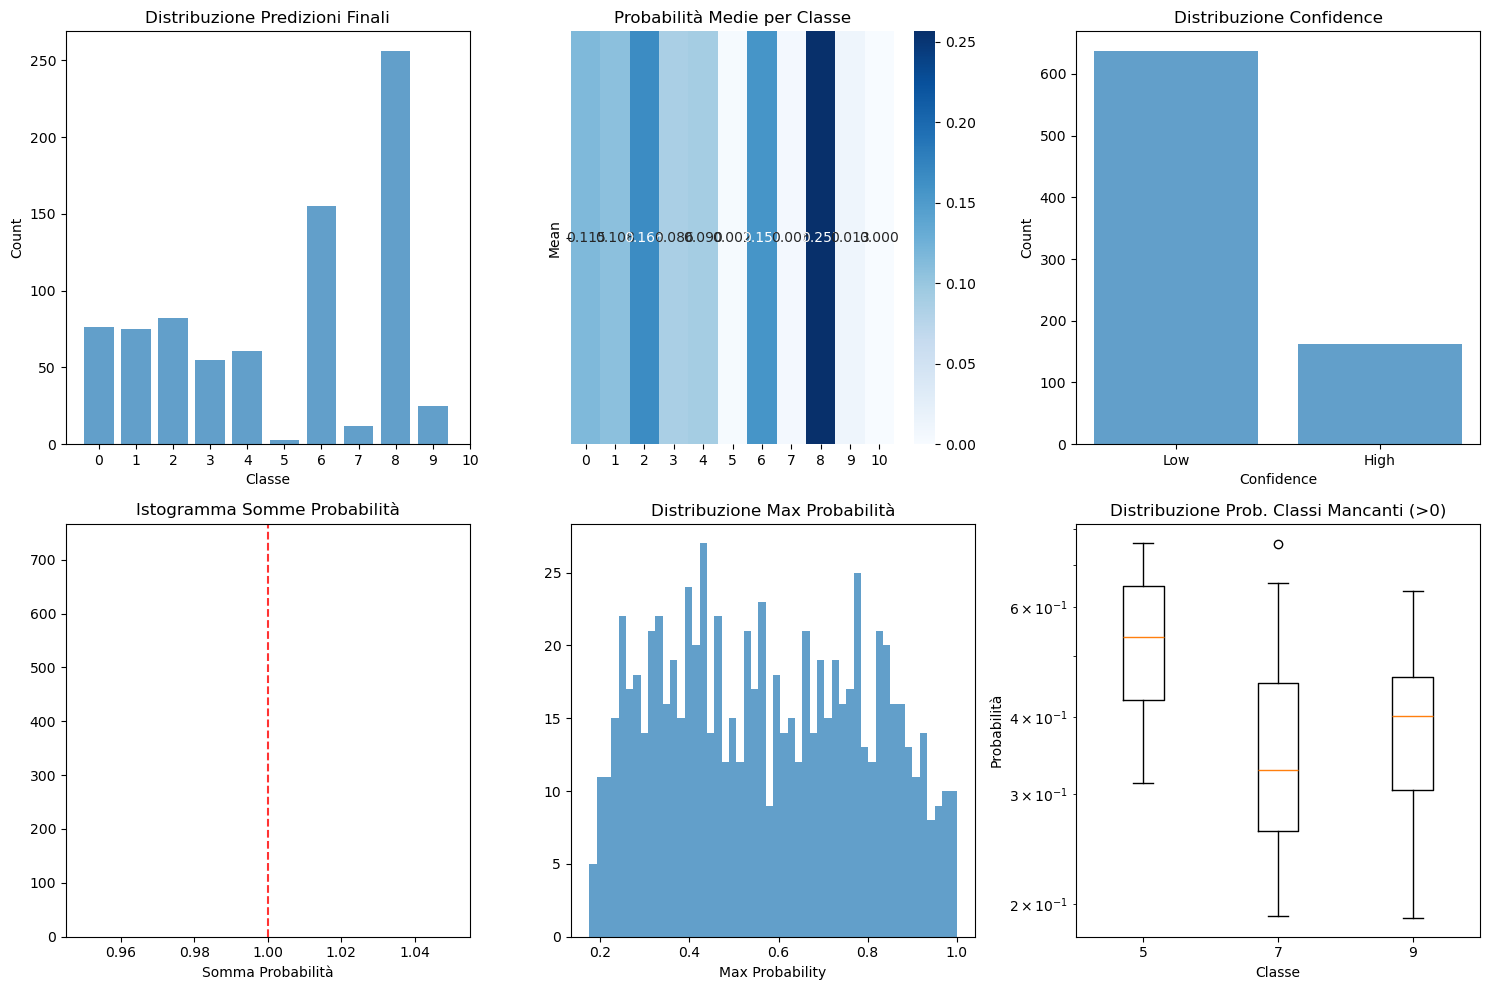

VALIDAZIONE FINALE SUBMISSION
✅ Tutte le colonne richieste presenti
✅ Tutte le probabilità sono non-negative
✅ Tutte le probabilità sono ≤ 1
✅ Probabilità correttamente normalizzate
✅ Valori confidence corretti (0 o 1)
✅ Nessun ID duplicato

🎉 SUBMISSION VALIDA!
   • Shape: (800, 13)
   • Range ID: [1, 800]

💾 Pronto per salvare:
probs_df.to_csv('submission.csv', index=False)

📋 STATISTICHE FINALI:
   • Predizioni classi mancanti: 40 / 800 (5.0%)
   • Predizioni classi base (4,6,8): 472 / 800 (59.0%)


In [35]:
# ============================================
# ANALISI E VALIDAZIONE SUBMISSION
# ============================================

import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 1) ANALISI DELLE PROBABILITÀ
# -------------------------
def analyze_submission(probs_df, y_tr=None):
    print("=" * 60)
    print("ANALISI SUBMISSION")
    print("=" * 60)
    
    # Statistiche base
    prob_cols = [f"prob_{i}" for i in range(11)]
    
    print(f"📊 STATISTICHE GENERALI:")
    print(f"   • Numero predizioni: {len(probs_df)}")
    print(f"   • Confidence alta: {probs_df['confidence'].sum()} ({probs_df['confidence'].mean():.1%})")
    
    # Verifica normalizzazione
    prob_sums = probs_df[prob_cols].sum(axis=1)
    print(f"   • Range somma probabilità: [{prob_sums.min():.6f}, {prob_sums.max():.6f}]")
    if not np.allclose(prob_sums, 1.0, rtol=1e-4):
        print("   ⚠️  Alcune righe non sono perfettamente normalizzate!")
    else:
        print("   ✅ Tutte le probabilità sono normalizzate")
    
    # Distribuzione predizioni
    y_pred = probs_df[prob_cols].values.argmax(axis=1)
    unique, counts = np.unique(y_pred, return_counts=True)
    
    print(f"\n📈 DISTRIBUZIONE PREDIZIONI:")
    for cls, cnt in zip(unique, counts):
        pct = cnt / len(probs_df) * 100
        print(f"   • Classe {cls}: {cnt:5d} ({pct:5.1f}%)")
    
    # Focus su classi mancanti
    missing_classes = [5, 7, 9]
    total_missing = sum(probs_df[f"prob_{c}"].sum() for c in missing_classes)
    print(f"\n🎯 CLASSI MANCANTI (5, 7, 9):")
    print(f"   • Probabilità totale trasferita: {total_missing:.4f}")
    for c in missing_classes:
        prob_sum = probs_df[f"prob_{c}"].sum()
        pred_count = (y_pred == c).sum()
        print(f"   • Classe {c}: prob_sum={prob_sum:7.4f}, predizioni={pred_count:4d}")
    
    # Analisi confidence
    high_conf = probs_df[probs_df['confidence'] == 1]
    low_conf = probs_df[probs_df['confidence'] == 0]
    
    print(f"\n🎯 ANALISI CONFIDENCE:")
    if len(high_conf) > 0:
        max_probs_high = high_conf[prob_cols].max(axis=1)
        print(f"   • High confidence: media max_prob = {max_probs_high.mean():.3f}")
    if len(low_conf) > 0:
        max_probs_low = low_conf[prob_cols].max(axis=1)
        print(f"   • Low confidence:  media max_prob = {max_probs_low.mean():.3f}")
    
    return y_pred, prob_sums

# -------------------------
# 2) VISUALIZZAZIONI
# -------------------------
def plot_submission_analysis(probs_df, figsize=(15, 10)):
    prob_cols = [f"prob_{i}" for i in range(11)]
    y_pred = probs_df[prob_cols].values.argmax(axis=1)
    
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.ravel()
    
    # 1) Distribuzione predizioni
    unique, counts = np.unique(y_pred, return_counts=True)
    axes[0].bar(unique, counts, alpha=0.7)
    axes[0].set_title('Distribuzione Predizioni Finali')
    axes[0].set_xlabel('Classe')
    axes[0].set_ylabel('Count')
    axes[0].set_xticks(range(11))
    
    # 2) Heatmap probabilità medie per classe
    mean_probs = probs_df[prob_cols].mean().values.reshape(1, -1)
    sns.heatmap(mean_probs, annot=True, fmt='.3f', 
                xticklabels=range(11), yticklabels=['Mean'], 
                ax=axes[1], cmap='Blues')
    axes[1].set_title('Probabilità Medie per Classe')
    
    # 3) Confidence distribution
    conf_counts = probs_df['confidence'].value_counts()
    axes[2].bar(conf_counts.index, conf_counts.values, alpha=0.7)
    axes[2].set_title('Distribuzione Confidence')
    axes[2].set_xlabel('Confidence')
    axes[2].set_ylabel('Count')
    axes[2].set_xticks([0, 1])
    axes[2].set_xticklabels(['Low', 'High'])
    
    # 4) Prob sum histogram
    prob_sums = probs_df[prob_cols].sum(axis=1)
    axes[3].hist(prob_sums, bins=50, alpha=0.7)
    axes[3].set_title('Istogramma Somme Probabilità')
    axes[3].set_xlabel('Somma Probabilità')
    axes[3].axvline(1.0, color='red', linestyle='--', alpha=0.8)
    
    # 5) Max probability distribution
    max_probs = probs_df[prob_cols].max(axis=1)
    axes[4].hist(max_probs, bins=50, alpha=0.7)
    axes[4].set_title('Distribuzione Max Probabilità')
    axes[4].set_xlabel('Max Probability')
    
    # 6) Missing classes focus
    missing_cols = ['prob_5', 'prob_7', 'prob_9']
    missing_data = probs_df[missing_cols].values
    
    # Filtra valori > 0 per il log scale
    missing_data_filtered = []
    labels_filtered = []
    for i, col in enumerate([5, 7, 9]):
        data_col = missing_data[:, i]
        data_positive = data_col[data_col > 0]
        if len(data_positive) > 0:
            missing_data_filtered.append(data_positive)
            labels_filtered.append(str(col))
    
    if missing_data_filtered:
        axes[5].boxplot(missing_data_filtered, labels=labels_filtered)
        axes[5].set_title('Distribuzione Prob. Classi Mancanti (>0)')
        axes[5].set_xlabel('Classe')
        axes[5].set_ylabel('Probabilità')
        axes[5].set_yscale('log')
    else:
        # Se non ci sono valori > 0, mostra un barplot semplice
        missing_sums = probs_df[missing_cols].sum().values
        axes[5].bar([5, 7, 9], missing_sums, alpha=0.7)
        axes[5].set_title('Somma Prob. Classi Mancanti')
        axes[5].set_xlabel('Classe')
        axes[5].set_ylabel('Somma Probabilità')
    
    plt.tight_layout()
    plt.show()

# -------------------------
# 3) VALIDAZIONE FINALE
# -------------------------
def validate_submission(probs_df):
    print("=" * 60)
    print("VALIDAZIONE FINALE SUBMISSION")
    print("=" * 60)
    
    prob_cols = [f"prob_{i}" for i in range(11)]
    issues = []
    
    # 1) Check colonne obbligatorie
    required_cols = ['id'] + prob_cols + ['confidence']
    missing_cols = [c for c in required_cols if c not in probs_df.columns]
    if missing_cols:
        issues.append(f"❌ Colonne mancanti: {missing_cols}")
    else:
        print("✅ Tutte le colonne richieste presenti")
    
    # 2) Check valori probabilità
    probs_matrix = probs_df[prob_cols].values
    if np.any(probs_matrix < 0):
        issues.append("❌ Alcune probabilità sono negative")
    else:
        print("✅ Tutte le probabilità sono non-negative")
    
    if np.any(probs_matrix > 1):
        issues.append("❌ Alcune probabilità sono > 1")
    else:
        print("✅ Tutte le probabilità sono ≤ 1")
    
    # 3) Check normalizzazione
    prob_sums = probs_matrix.sum(axis=1)
    if not np.allclose(prob_sums, 1.0, rtol=1e-4):
        issues.append(f"❌ Normalizzazione: range [{prob_sums.min():.6f}, {prob_sums.max():.6f}]")
    else:
        print("✅ Probabilità correttamente normalizzate")
    
    # 4) Check confidence
    conf_values = probs_df['confidence'].unique()
    if not set(conf_values).issubset({0, 1}):
        issues.append(f"❌ Confidence deve essere 0 o 1, trovati: {conf_values}")
    else:
        print("✅ Valori confidence corretti (0 o 1)")
    
    # 5) Check ID duplicati
    if probs_df['id'].duplicated().any():
        issues.append("❌ ID duplicati trovati")
    else:
        print("✅ Nessun ID duplicato")
    
    # 6) Summary
    if issues:
        print(f"\n⚠️  PROBLEMI TROVATI ({len(issues)}):")
        for issue in issues:
            print(f"   {issue}")
        return False
    else:
        print(f"\n🎉 SUBMISSION VALIDA!")
        print(f"   • Shape: {probs_df.shape}")
        print(f"   • Range ID: [{probs_df['id'].min()}, {probs_df['id'].max()}]")
        return True

# -------------------------
# 4) ANALISI COMPLETA
# -------------------------
print("Eseguendo analisi completa della submission...")

# Analisi statistiche
y_pred, prob_sums = analyze_submission(probs_df, y_tr)

# Visualizzazioni
print(f"\nCreando visualizzazioni...")
plot_submission_analysis(probs_df)

# Validazione finale
is_valid = validate_submission(probs_df)

if is_valid:
    print(f"\n💾 Pronto per salvare:")
    print(f"probs_df.to_csv('submission.csv', index=False)")
    
    # Statistiche finali utili
    print(f"\n📋 STATISTICHE FINALI:")
    missing_pred = sum((y_pred == c).sum() for c in [5, 7, 9])
    print(f"   • Predizioni classi mancanti: {missing_pred} / {len(probs_df)} ({missing_pred/len(probs_df):.1%})")
    
    base_pred = sum((y_pred == c).sum() for c in [4, 6, 8])
    print(f"   • Predizioni classi base (4,6,8): {base_pred} / {len(probs_df)} ({base_pred/len(probs_df):.1%})")
else:
    print(f"\n🔧 Correggi i problemi prima di procedere con la submission.")

c:\Users\dswal\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\dswal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\dswal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\dswal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_N

Optimal number of components: 2 (BIC: 1644.37)

Cluster Statistics:
Cluster 0: size=20, mean_prob_9=0.398, mean_prob_10=0.000, margin=0.398 <- SUSPICIOUS
Cluster 1: size=5, mean_prob_9=0.430, mean_prob_10=0.000, margin=0.430

Summary:
Total samples: 25
Suspicious (75th percentile): 7
Highly suspicious (90th percentile): 3
Threshold 75%: 0.849
Threshold 90%: 0.905


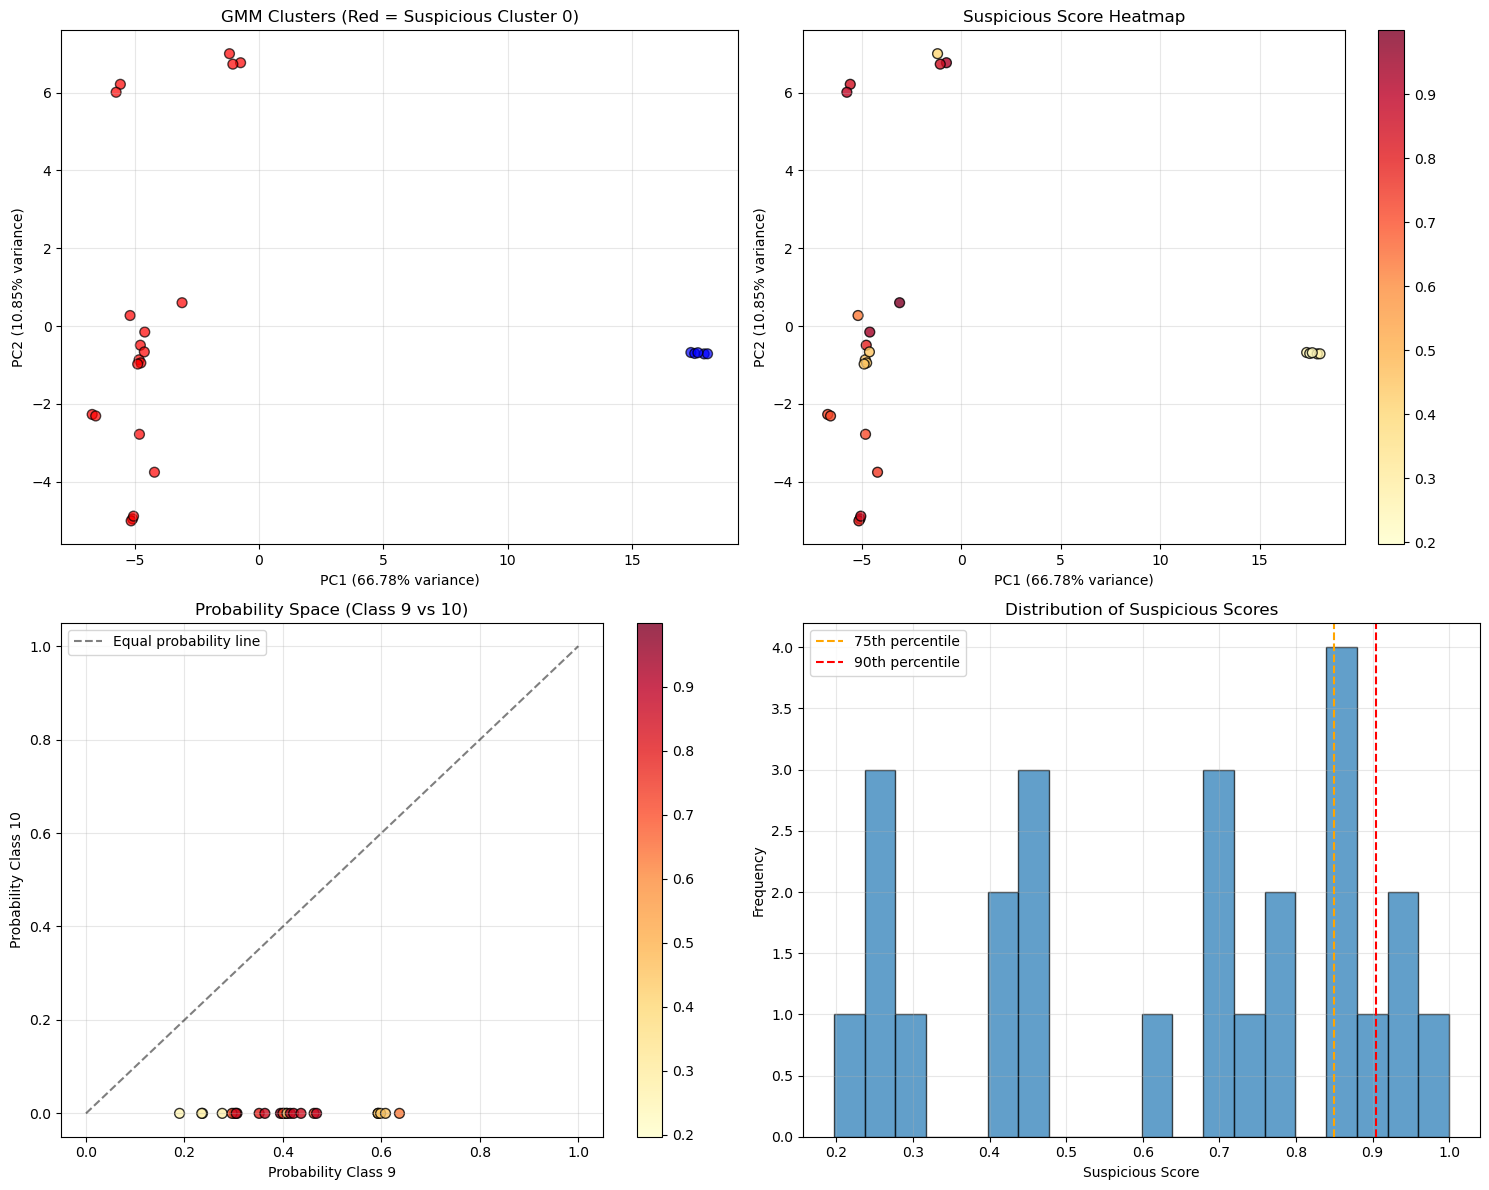


Top 10 most suspicious samples:
 id   prob_9  prob_10   margin  cluster  responsibility_suspicious  suspicious_score  is_suspicious_90
124 0.190000      0.0 0.190000        0                        1.0          1.000000              True
 36 0.236667      0.0 0.236667        0                        1.0          0.943540              True
390 0.235000      0.0 0.235000        0                        1.0          0.920045              True
506 0.276667      0.0 0.276667        0                        1.0          0.881725             False
363 0.301667      0.0 0.301667        0                        1.0          0.859130             False
749 0.306667      0.0 0.306667        0                        1.0          0.852174             False
737 0.296667      0.0 0.296667        0                        1.0          0.849140             False
453 0.305000      0.0 0.305000        0                        1.0          0.844637             False
496 0.351667      0.0 0.351667        0 

In [42]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set environment variable to avoid KMeans warning
os.environ['OMP_NUM_THREADS'] = '1'

# Enhanced parameters
GMM_N_INIT = 10  # Increased for more stability
GMM_COV_TYPE = "full"
RNG = 42
MIN_N = 10

def analyze_class_confusion(probs_df, test_df, X_tr, test_full, target_class=9, confusion_class=10):
    """
    Enhanced analysis for detecting potential misclassification between two classes
    """
    prob_cols = [f"prob_{c}" for c in range(11)]
    P = probs_df[prob_cols].to_numpy()
    top1 = np.argmax(P, axis=1)
    mask = (top1 == target_class)
    idx = np.where(mask)[0]

    if idx.size < MIN_N:
        print(f"Insufficient data: only {idx.size} samples with top1={target_class} (<{MIN_N}).")
        return None

    # Prepare features
    scaler = StandardScaler().fit(X_tr)
    X_target = scaler.transform(test_full)[mask]
    
    # Determine optimal number of components using BIC/AIC
    n_components_range = range(2, min(6, idx.size // 5))  # Up to 5 components, but not more than samples/5
    bic_scores = []
    aic_scores = []
    models = []
    
    for n_comp in n_components_range:
        gmm = GaussianMixture(
            n_components=n_comp,
            covariance_type=GMM_COV_TYPE,
            n_init=GMM_N_INIT,
            random_state=RNG,
            max_iter=200
        )
        try:
            gmm.fit(X_target)
            bic_scores.append(gmm.bic(X_target))
            aic_scores.append(gmm.aic(X_target))
            models.append(gmm)
        except:
            bic_scores.append(np.inf)
            aic_scores.append(np.inf)
            models.append(None)
    
    # Select best model based on BIC
    best_idx = np.argmin(bic_scores)
    best_n_comp = n_components_range[best_idx]
    best_gmm = models[best_idx]
    
    if best_gmm is None:
        print("GMM fitting failed for all component numbers.")
        return None
    
    print(f"Optimal number of components: {best_n_comp} (BIC: {bic_scores[best_idx]:.2f})")
    
    # Fit final model
    resp_hard = best_gmm.predict(X_target)
    resp_soft = best_gmm.predict_proba(X_target)
    
    # Enhanced cluster interpretation
    prob_target = P[mask, target_class]
    prob_confusion = P[mask, confusion_class]
    
    # For each cluster, compute statistics
    cluster_stats = {}
    for c in range(best_n_comp):
        cluster_mask = (resp_hard == c)
        if np.any(cluster_mask):
            cluster_stats[c] = {
                'size': np.sum(cluster_mask),
                'mean_prob_target': prob_target[cluster_mask].mean(),
                'mean_prob_confusion': prob_confusion[cluster_mask].mean(),
                'std_prob_target': prob_target[cluster_mask].std(),
                'margin_mean': (prob_target[cluster_mask] - prob_confusion[cluster_mask]).mean()
            }
    
    # Identify suspicious cluster (lowest margin between target and confusion class)
    suspicious_cluster = min(cluster_stats.keys(), 
                           key=lambda c: cluster_stats[c]['margin_mean'])
    
    print(f"\nCluster Statistics:")
    for c, stats in cluster_stats.items():
        marker = " <- SUSPICIOUS" if c == suspicious_cluster else ""
        print(f"Cluster {c}: size={stats['size']}, "
              f"mean_prob_{target_class}={stats['mean_prob_target']:.3f}, "
              f"mean_prob_{confusion_class}={stats['mean_prob_confusion']:.3f}, "
              f"margin={stats['margin_mean']:.3f}{marker}")
    
    # Enhanced scoring
    # 1. Responsibility towards suspicious cluster
    resp_suspicious = resp_soft[:, suspicious_cluster]
    
    # 2. Probability margin (lower = more suspicious)
    margin = prob_target - prob_confusion
    margin_norm = (margin - margin.min()) / (margin.ptp() + 1e-9)
    
    # 3. Confidence in target class (lower = more suspicious)  
    confidence_norm = (prob_target - prob_target.min()) / (prob_target.ptp() + 1e-9)
    
    # 4. Entropy of probability distribution (higher = more uncertain)
    prob_dist = P[mask]
    entropy = -np.sum(prob_dist * np.log(prob_dist + 1e-9), axis=1)
    entropy_norm = (entropy - entropy.min()) / (entropy.ptp() + 1e-9)
    
    # Combined suspicious score
    suspicious_score = (0.4 * resp_suspicious + 
                       0.3 * (1.0 - margin_norm) + 
                       0.2 * (1.0 - confidence_norm) + 
                       0.1 * entropy_norm)
    
    # Dynamic threshold based on distribution
    thresh_75 = np.quantile(suspicious_score, 0.75)
    thresh_90 = np.quantile(suspicious_score, 0.90)
    
    # Create output dataframe
    result_df = pd.DataFrame({
        "id": test_df.loc[mask, "id"].values,
        f"prob_{target_class}": prob_target,
        f"prob_{confusion_class}": prob_confusion,
        "margin": margin,
        "entropy": entropy,
        "cluster": resp_hard,
        "suspicious_cluster": suspicious_cluster,
        f"responsibility_suspicious": resp_suspicious,
        "suspicious_score": suspicious_score,
        "is_suspicious_75": suspicious_score >= thresh_75,
        "is_suspicious_90": suspicious_score >= thresh_90
    })
    
    # Sort by suspicion level
    result_df = result_df.sort_values("suspicious_score", ascending=False).reset_index(drop=True)
    
    print(f"\nSummary:")
    print(f"Total samples: {len(result_df)}")
    print(f"Suspicious (75th percentile): {result_df['is_suspicious_75'].sum()}")
    print(f"Highly suspicious (90th percentile): {result_df['is_suspicious_90'].sum()}")
    print(f"Threshold 75%: {thresh_75:.3f}")
    print(f"Threshold 90%: {thresh_90:.3f}")
    
    # Visualization
    create_enhanced_visualization(X_target, resp_hard, suspicious_cluster, 
                                suspicious_score, result_df, target_class, confusion_class)
    
    return result_df, best_gmm, cluster_stats

def create_enhanced_visualization(X, resp_hard, suspicious_cluster, suspicious_score, 
                                result_df, target_class, confusion_class):
    """Create comprehensive visualization"""
    
    # PCA for dimensionality reduction
    pca = PCA(n_components=2, random_state=RNG)
    X_2d = pca.fit_transform(X)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Clusters with suspicion coloring
    ax1 = axes[0, 0]
    colors = ['red' if c == suspicious_cluster else 'blue' for c in resp_hard]
    scatter1 = ax1.scatter(X_2d[:, 0], X_2d[:, 1], c=colors, alpha=0.7, s=50, edgecolor='k')
    ax1.set_title(f'GMM Clusters (Red = Suspicious Cluster {suspicious_cluster})')
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Suspicious score heatmap
    ax2 = axes[0, 1]
    scatter2 = ax2.scatter(X_2d[:, 0], X_2d[:, 1], c=suspicious_score, 
                          cmap='YlOrRd', s=50, edgecolor='k', alpha=0.8)
    ax2.set_title('Suspicious Score Heatmap')
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax2.grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=ax2)
    
    # Plot 3: Probability scatter
    ax3 = axes[1, 0]
    scatter3 = ax3.scatter(result_df[f'prob_{target_class}'], result_df[f'prob_{confusion_class}'], 
                          c=suspicious_score, cmap='YlOrRd', s=50, edgecolor='k', alpha=0.8)
    ax3.set_xlabel(f'Probability Class {target_class}')
    ax3.set_ylabel(f'Probability Class {confusion_class}')
    ax3.set_title(f'Probability Space (Class {target_class} vs {confusion_class})')
    ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Equal probability line')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    plt.colorbar(scatter3, ax=ax3)
    
    # Plot 4: Score distribution
    ax4 = axes[1, 1]
    ax4.hist(suspicious_score, bins=20, alpha=0.7, edgecolor='k')
    ax4.axvline(np.quantile(suspicious_score, 0.75), color='orange', linestyle='--', 
                label='75th percentile')
    ax4.axvline(np.quantile(suspicious_score, 0.90), color='red', linestyle='--', 
                label='90th percentile')
    ax4.set_xlabel('Suspicious Score')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Distribution of Suspicious Scores')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

# Usage example (replace with your actual data):
result_df, gmm_model, stats = analyze_class_confusion(
     probs_df, test_df, X_tr, test_full, target_class=9, confusion_class=10
)

# Display top suspicious samples
print("\nTop 10 most suspicious samples:")
display_cols = ["id", "prob_9", "prob_10", "margin", "cluster", 
               "responsibility_suspicious", "suspicious_score", "is_suspicious_90"]
print(result_df[display_cols].head(10).to_string(index=False))